In [58]:
from model import FreckerDataSet
from torch.utils.data import DataLoader, random_split
import torch
import torch.optim as optim
import torch.nn.functional as F
from model import MaskLoss, FreckersNet
from torch.optim.lr_scheduler import OneCycleLR

In [59]:
# file = r"C:\Users\lucyc\Desktop\freckers_data\P1.h5"
# file2 = r"C:\Users\lucyc\Desktop\freckers_data\P2.h5"
# dataset1 = FreckerDataSet(file_path=file)
# dataset2 = FreckerDataSet(file_path=file2)

#dataset = torch.utils.data.ConcatDataset([dataset1, dataset2])

file_base_path = r"C:\Users\lucyc\Desktop\data"
versions = [str(i) for i in range(8, 15)]
datasets = [FreckerDataSet(file_base_path + "\\" + v + ".h5") for v in versions]

# # 合并两个数据集
dataset = torch.utils.data.ConcatDataset(datasets)

# dataset = FreckerDataSet(file_path=file)
# dataset = torch.utils.data.Subset(dataset, range(int(len(dataset) * (9/11)), len(dataset)))


# 按照顺序分割数据集
train_size = int(0.8 * len(dataset))  # 50% 用于训练
val_size = len(dataset) - train_size  # 50% 用于验证

# 使用 Subset 分割数据集
train_dataset = torch.utils.data.Subset(dataset, range(train_size))
val_dataset = torch.utils.data.Subset(dataset, range(train_size, len(dataset)))

train_dataset, _ = random_split(train_dataset, [int(0.1 * len(train_dataset)), len(train_dataset) - int(0.1 * len(train_dataset))])
val_dataset, _ = random_split(val_dataset, [int(0.1 * len(val_dataset)), len(val_dataset) - int(0.1 * len(val_dataset))])
# 随机分割
# train_dataset, val_dataset = random_split(dataset, [int(0.5 * len(dataset)), len(dataset) - int(0.5 * len(dataset))])
# print(f"合并后的数据集大小: {len(train_dataset)}")

# # 定义训练集和验证集的大小
# train_size = int(0.8 * len(dataset))  # 80% 用于训练
# val_size = len(dataset) - train_size  # 20% 用于验证

# # 使用 random_split 分割数据集
# train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 64
shuffle = True
num_workers = 1

# 创建 DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, persistent_workers=True)


In [56]:
train_dataset[0][0].shape

torch.Size([16, 8, 8])

In [57]:
train_dataset[0][0]

tensor([[[0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 1., 1.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 1., 0.,  ..., 0., 1., 1.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.]],

        [[0., 0., 1.,  ..., 1., 1., 1.],
         [0., 1., 0.,  ..., 1., 0., 0.],
         [1., 0., 0.,  ..., 1., 0., 0.],
         ...,
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 1., 0., 0.],
         [1., 1., 1.,  ..., 0., 1., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 0., 0.,  ..., 0., 1., 1.],
         [0., 0., 0., 

In [43]:
train_dataset[13][2]

tensor(-1.1000)

In [63]:
model = FreckersNet()

In [64]:
num_epochs = 30
stop_epoch = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=0.01)
scheduler = OneCycleLR(
    optimizer,
    max_lr=0.001,  # 最大学习率
    steps_per_epoch=len(train_loader),
    epochs=num_epochs,
    pct_start=0.4  # warmup 的比例
)
mask_loss = MaskLoss()

train_loss_record = []
eval_loss_record = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for gameboard, action_prob, value in train_loader:
        gameboard = gameboard.to(device)
        action_prob = action_prob.to(device)
        value = value.to(device)

        optimizer.zero_grad()
        p_action_prob, p_value = model(gameboard)
        # 计算双损失
        loss_img = mask_loss(p_action_prob, action_prob)
        loss_prob = F.mse_loss(p_value.view(-1), value)
        total_loss = loss_img + loss_prob
        
        total_loss.backward()
        optimizer.step()
        scheduler.step()
        train_loss += total_loss.item()
    
    train_loss /= len(train_loader)
    train_loss_record.append(train_loss)

    model.eval()
    eval_loss = 0.0
    with torch.no_grad():
        for gameboard, action_prob, value in val_loader:
            gameboard = gameboard.to(device)
            action_prob = action_prob.to(device)
            value = value.to(device)

            p_action_prob, p_value = model(gameboard)
            loss_img = mask_loss(p_action_prob, action_prob)
            loss_prob = F.mse_loss(p_value.view(-1), value)
            total_loss = loss_img + loss_prob
            
            eval_loss += total_loss.item()
    
    eval_loss /= len(val_loader)
    eval_loss_record.append(eval_loss)

    print(f"Epoch {epoch+1}, Training Loss: {train_loss:.8f}, Validation Loss: {eval_loss:.8f}")

    if epoch == stop_epoch:
        torch.save(model, "C:\\Users\\lucyc\\Desktop\\P9-15.pth")



Epoch 1, Training Loss: 2.13170348, Validation Loss: 2.13900308
Epoch 2, Training Loss: 1.99771748, Validation Loss: 1.94691256
Epoch 3, Training Loss: 1.83447403, Validation Loss: 1.84997997
Epoch 4, Training Loss: 1.74151046, Validation Loss: 1.75030431
Epoch 5, Training Loss: 1.64225691, Validation Loss: 1.64946255
Epoch 6, Training Loss: 1.55895580, Validation Loss: 1.60130259
Epoch 7, Training Loss: 1.50196197, Validation Loss: 1.54836119
Epoch 8, Training Loss: 1.46997017, Validation Loss: 1.57397339
Epoch 9, Training Loss: 1.44854702, Validation Loss: 1.51525644
Epoch 10, Training Loss: 1.42773095, Validation Loss: 1.49124402
Epoch 11, Training Loss: 1.40913674, Validation Loss: 1.50366664
Epoch 12, Training Loss: 1.40458631, Validation Loss: 1.49561272
Epoch 13, Training Loss: 1.37595576, Validation Loss: 1.45835489
Epoch 14, Training Loss: 1.35824471, Validation Loss: 1.44490482
Epoch 15, Training Loss: 1.34380446, Validation Loss: 1.44864351
Epoch 16, Training Loss: 1.3511599

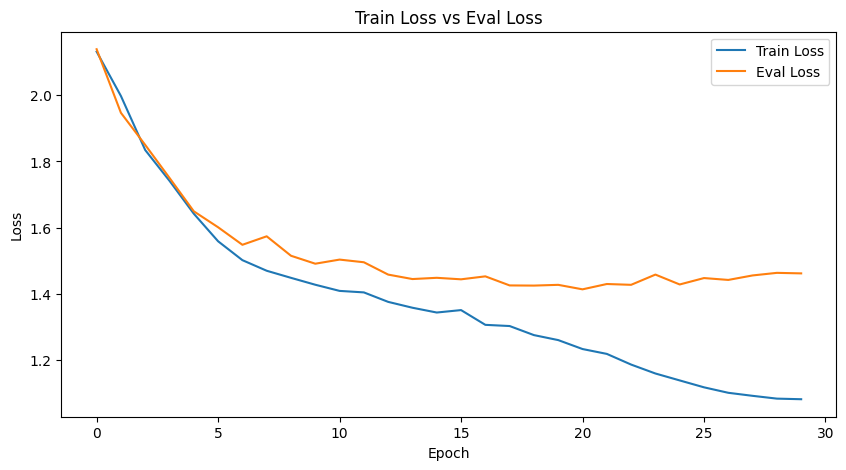

In [65]:
import matplotlib.pyplot as plt

# 绘制训练损失和验证损失的对比图
plt.figure(figsize=(10, 5))
plt.plot(train_loss_record, label='Train Loss')
plt.plot(eval_loss_record, label='Eval Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss vs Eval Loss')
plt.legend()
plt.show()


In [18]:
import torch
from fnet import MaskLoss, Conv3DStack
model = torch.load("C:\\Users\\lucyc\\Desktop\\freckers_data\\P2_Mini.pth", weights_only=False)
model2 = torch.load("C:\\Users\\lucyc\\Desktop\\freckers_data\\P1_Mini.pth", weights_only=False)
#model2 = Conv3DStack()

In [20]:
from mcts import mcts_data_collect, mcts_competition
class MctsConfig:
    def __init__(self) -> None:
        self.c = 1.5
        self.t = 1
        self.finish = False
        self.visulze = False
        self.small = 0.0000001

        self.dirichlet_alpha = 0.03
        self.dirichlet_epsilon = 0.25

#res1 = mcts_competition(model, 1, r"C:\Users\lucyc\Desktop\freckers_data\temp.h5", MctsConfig(), 3, 150, model2)
print(mcts_competition(model2, 1, r"C:\Users\lucyc\Desktop\freckers_data\temp.h5", MctsConfig(), 3, 150, model, visulze=True))
print(mcts_competition(model2, 1, r"C:\Users\lucyc\Desktop\freckers_data\temp.h5", MctsConfig(), 3, 150, model, visulze=False))

线程 1 第 0 轮游戏  第 0 步 模拟进行中

Rounds:  1
🟢🔴🔴🔴🔴🔴🔴🟢
⚪🟢🟢🟢🟢🟢🟢⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪🟢🟢🟢🟢🟢🟢⚪
🔵⚪🔵🔵🔵🔵🔵🟢
move action:  (7, 1, 7, 0, False)
线程 1 第 0 轮游戏  第 1 步 模拟进行中

Rounds:  2
🔴🔴⚪🔴🔴🔴🔴🟢
⚪🟢🟢🟢🟢🟢🟢⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪🟢🟢🟢🟢🟢🟢⚪
🔵⚪🔵🔵🔵🔵🔵🟢
move action:  (0, 2, 0, 0, False)
线程 1 第 0 轮游戏  第 2 步 模拟进行中

Rounds:  3
🔴🔴⚪🔴🔴🔴🔴🟢
⚪🟢🟢🟢🟢🟢🟢⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪🟢🟢🔵🟢🟢🟢⚪
🔵⚪🔵🔵⚪🔵🔵🟢
move action:  (7, 4, 6, 3, False)
线程 1 第 0 轮游戏  第 3 步 模拟进行中

Rounds:  4
🔴⚪⚪🔴🔴🔴🔴🟢
⚪🟢🔴🟢🟢🟢🟢⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪🟢🟢🔵🟢🟢🟢⚪
🔵⚪🔵🔵⚪🔵🔵🟢
move action:  (0, 1, 1, 2, False)
线程 1 第 0 轮游戏  第 4 步 模拟进行中

Rounds:  5
🔴⚪⚪🔴🔴🔴🔴🟢
⚪🟢🔴🟢🟢🟢🟢⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪🟢🟢🔵🟢🟢🔵⚪
🔵⚪🔵🔵⚪⚪🔵🟢
move action:  (7, 5, 6, 6, False)
线程 1 第 0 轮游戏  第 5 步 模拟进行中

Rounds:  6
🔴⚪⚪🔴🔴⚪🔴🔴
⚪🟢🔴🟢🟢🟢🟢⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪🟢🟢🔵🟢🟢🔵⚪
🔵⚪🔵🔵⚪⚪🔵🟢
move action:  (0, 5, 0, 7, False)
线程 1 第 0 轮游戏  第 6 步 模拟进行中

Rounds:  7
🔴⚪⚪🔴🔴⚪🔴🔴
⚪🟢🔴🟢🟢🟢🟢⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪⚪⚪⚪⚪⚪⚪⚪
⚪🟢🟢🔵🔵🟢🔵⚪
🔵⚪🔵⚪⚪⚪🔵🟢
move action:  (7, 3, 6, 4,

KeyboardInterrupt: 

In [ ]:
import threading
import time
from mcts import mcts_data_collect

#(model, thread_num, file, rounds=100, sim_step=300)
# 创建多个线程
threads = []
for i in range(8):
    thread = threading.Thread(target=mcts_data_collect, 
            args=(model, i+1, f"C:\\Users\\lucyc\\Desktop\\freckers_data\\batch_1.h5", 30, 500))
    threads.append(thread)
    thread.start()

# 等待所有线程完成
for thread in threads:
    thread.join()


In [12]:
torch.save(model, "C:\\Users\\lucyc\\Desktop\\freckers_data\\batch_2_no_inverse.pth")

In [50]:
import torch

In [51]:
data = torch.load(r"C:\Users\lucyc\Desktop\models\5.pth")

In [9]:
data.keys()

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'loss_rec'])

In [52]:
import torch

In [53]:
data = torch.load(r"C:\Users\lucyc\Desktop\models\5.pth")
data["loss_rec"]


[1.939631720383962,
 1.6946175268718175,
 1.6437556743621826,
 1.6129035552342732,
 1.578013573374067]